In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as patches
import jax.numpy as jnp 
from jax import grad, hessian, jacfwd
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['lines.linewidth'] = 2
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
mpl.rc('font', size=18) 

# disable LaTeX rendering
plt.rcParams['text.usetex'] = False

x1 = λr (x[...,0])
x2 = V0 (x[...,1])
x3 = D (x[...,2])
x4 = cl_cd (x[...,3])

In [88]:
# define wind power function
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[0])*(x[0]+(1.32+((x[0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[0]**2/((x[3])*((x[0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[1])**2*(x[2])**2

def f(a0):
    return 16*a0**3-24*a0**2+(-3*(x0_value)**2+9)*a0+((x0_value)**2-1)

def f_prime(a0):
    return 48*a0**2-48*a0+(9-3*(x0_value)**2)

def newton_raphson(f, df, a0, tol):
    if abs(f(a0)) < tol:
        return a0
    else:
        return newton_raphson(f, df, a0 - f(a0)/df(a0), tol)

# define relevant equations
x0_range = jnp.linspace(5.0, 10.0, 10) 
a_values = []
CBe_values = []
for x0_value in x0_range:
    a = newton_raphson(f, f_prime, 0.3, 1e-3)
    CBe = 4*a*(1-a)
    a_values.append(a)
    CBe_values.append(CBe)

    #print("a for x0 =", x0_value, ":", a)

# define constraints
c1 = lambda x: 0.8883 - CBe_values[x0_range.tolist().index(x[0])]
c2 = lambda x: 158 - 2 * x[0] * x[1] / x[2]

bounds = Bounds([5.0, 0.0, 120.0, 25.0], [10.0, 22.0, 145.0, 100.0])

x0_b = np.array([5.0, 0.0, 120.0, 25.0])
x0_m = np.array([7.5, 11.0, 132.0, 70.0])
x0_e = np.array([10.0, 22.0, 145.0, 100.0])



a_values_np = jnp.array(a_values)
CBe_values_np = jnp.array(CBe_values)
#print("All values of a:", a_values_np)
#print(CBe_values_np)

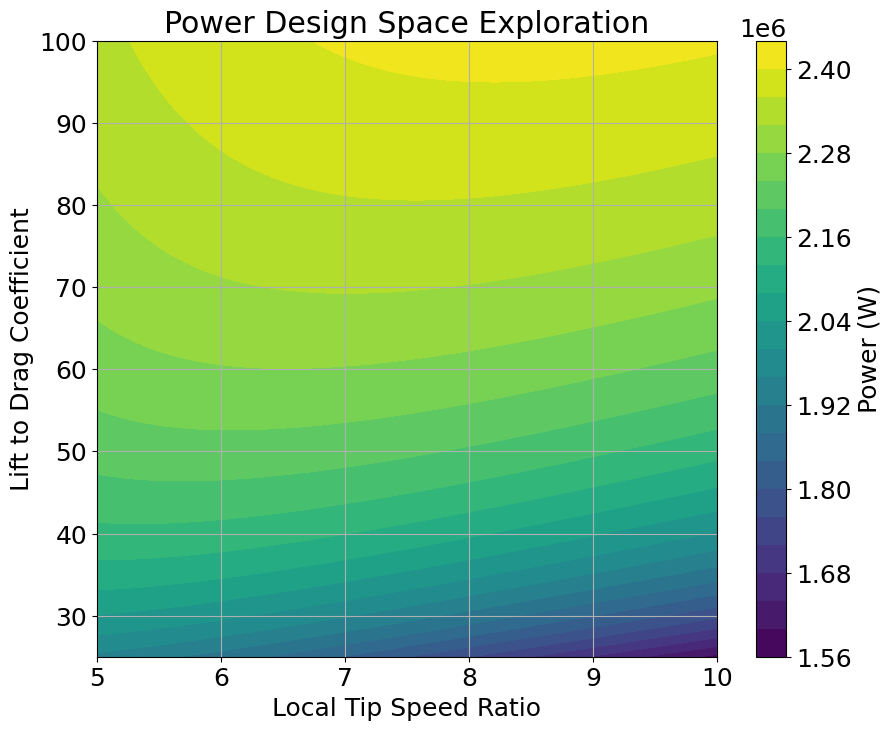

In [84]:
# let us fix x[1] (V0) and x[2] (D) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((x[...,3])*((x[...,0])+0.5/beta))
    return (np.pi/8)*CP*rho*(22)**2*(145)**2

# create meshgrid 
x0_range = np.linspace(5.0, 10.0, 100)
x3_range = np.linspace(25.0, 100.0, 100)
X0, X3 = np.meshgrid(x0_range, x3_range)

X = np.stack((X0, np.full_like(X0, 22), np.full_like(X0, 145), X3), axis=-1)

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X3, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Lift to Drag Coefficient')
plt.title('Power Design Space Exploration')
plt.grid(True)
plt.show()


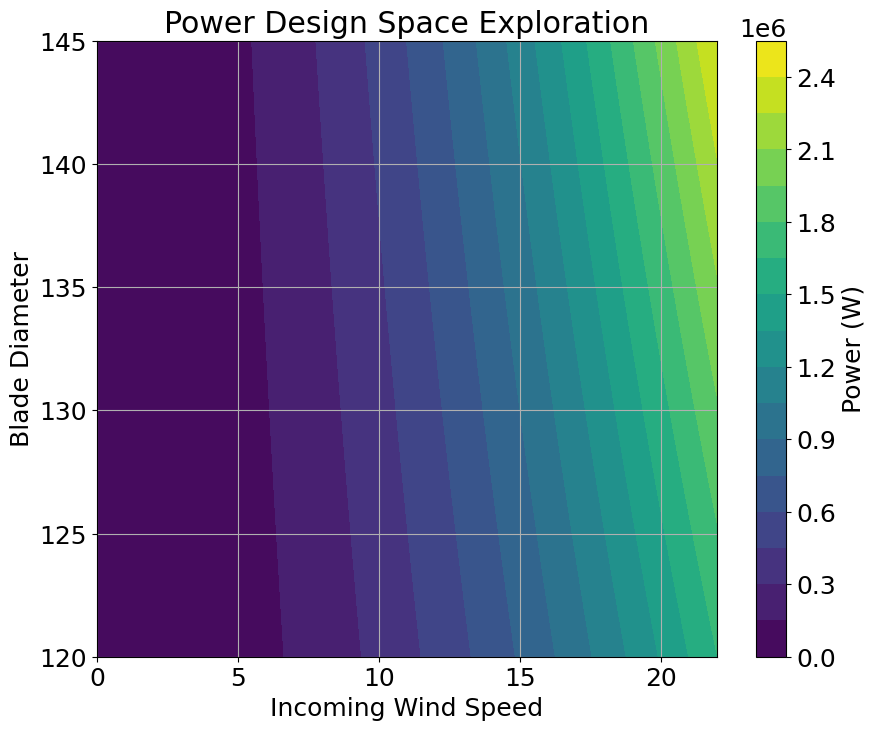

In [85]:
# let us fix x[0] (λr) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(10)*(10+(1.32+((10-8)/20)**2)/(beta**(2/3)))**-1-0.57*10**2/((100)*((10)+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(x[...,2])**2

# create meshgrid
x1_range = np.linspace(0.0, 22.0, 100)
x2_range = np.linspace(120.0, 145.0, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

X = np.stack((np.full_like(X1, 10),X1, X2,np.full_like(X2, 100)), axis=-1)

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X1, X2, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Incoming Wind Speed')
plt.ylabel('Blade Diameter')
plt.title('Power Design Space Exploration')
plt.grid(True)
plt.show()

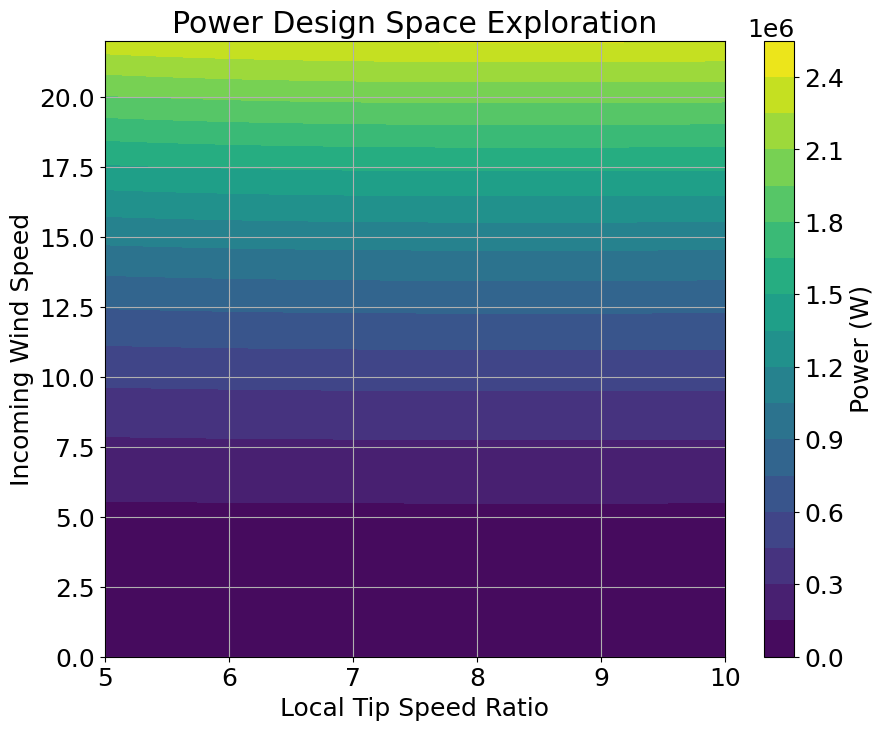

In [86]:
# let us fix x[2] (D) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((100)*((x[...,0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(145)**2

# create meshgrid
x0_range = np.linspace(5.0, 10.0, 100)
x1_range = np.linspace(0.0, 22.0, 100)
X0, X1 = np.meshgrid(x0_range, x1_range)

X = np.stack((X0, X1, np.full_like(X0, 145), np.full_like(X1, 100)), axis=-1)

# create contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X1, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Incoming Wind Speed')
plt.title('Power Design Space Exploration')
plt.grid(True)
plt.show()

In [90]:
# define constraints for SciPy minimize
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[0])*(x[0]+(1.32+((x[0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[0]**2/((x[3])*((x[0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[1])**2*(x[2])**2

ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}

k = 0

# define a callback function to store optimization histories
def callback_tr(x, state):
    global k
    k += 1
    
    xx_tr.append(x) # iterate xk
    fx_tr.append(state.fun) # function value
    c1x_tr.append(ineq_con1['fun'](x)) # constraint evaluation for c1 only
    c2x_tr.append(ineq_con2['fun'](x))
    
    constraint_vec_tr = [c1(x), c2(x)]
    constraint_history_tr.append(constraint_vec_tr)
    
    print(f'xk_tr {x}, fk_tr {state.fun}, c1 {c1(x)}, c2 {c2(x)}')
    
# starting point
x0 = np.array([5.0, 0.0, 120.0, 25.0])

xx_tr = [] 
fx_tr = []
c1x_tr = [] 
c2x_tr = [] 
constraint_history_tr = []

res = minimize(power, x0, method='trust-constr', jac=None,
               constraints=[ineq_con1, ineq_con2],
               options=None,
               bounds=bounds, callback=callback_tr)

xk_tr [  5.   0. 120.  25.], fk_tr 0.0, c1 0.0007032155990600586, c2 158.0


ValueError: Traced<ConcreteArray(5.035492897033691, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(5.035493, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x16a24d440>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x14c87ed90; to 'JaxprTracer' at 0x14c87f0b0>], out_avals=[ShapedArray(float32[])], primitive=squeeze, params={'dimensions': (0,)}, effects=frozenset(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x16a294630>, name_stack=NameStack(stack=(Transform(name='jvp'),)))) is not in list